## Cristopher Quispe

In [1]:
import numpy as np
from skimage import io, transform, color
from matplotlib import pyplot as plt
import scipy.ndimage as nd
from scipy.misc import imsave

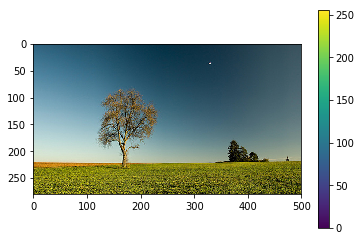

In [2]:
countryside = io.imread('countryside.jpg').astype(np.uint8)

plt.imshow(countryside)
plt.colorbar()

#### Funcion para calcular el gradiente

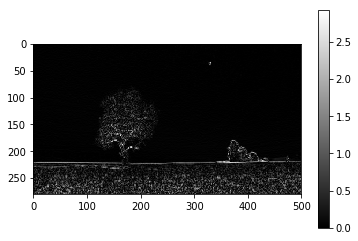

In [3]:
def gradient(img):
    dx = nd.sobel(color.rgb2gray(img), 0)
    return np.abs(dx)

plt.imshow(gradient(countryside), cmap='gray')
plt.colorbar()

#### Funcion del campus para marcar la linea a eliminar en la imagen

In [4]:
def markPath(mat, path, mark_as='red'):
    assert mark_as in ['red','green','blue','black','white']
    
    if len(mat.shape) == 2:
        mat = color.gray2rgb(mat)
    
    ret = np.zeros(mat.shape)
    ret[:,:,:] = mat[:,:,:]
    
    # Preprocess image
    if np.max(ret) < 1.1 or np.max(ret) > 256: # matrix is in float numbers
        ret -= np.min(ret)
        ret /= np.max(ret)
        ret *= 256
    
    # Determinate components
    if mark_as == 'red':
        r,g,b = 255,0,0
    elif mark_as == 'green':
        r,g,b = 0,255,0
    elif mark_as == 'blue':
        r,g,b = 0,0,255
    elif mark_as == 'white':
        r,g,b = 255,255,255
    elif mark_as == 'black':
        r,b,b = 0,0,0

    # Place R,G,B
    for i in path:
        ret[int(i[0]),int(i[1]),0] = r
        ret[int(i[0]),int(i[1]),1] = g
        ret[int(i[0]),int(i[1]),2] = b
    return ret.astype('uint8')

#### Funciones del algoritmo seam carving para esta practica, tenemos la funcion "lines" que nos calcula la linea a eliminar dada una imagen por parametro, se encarga de mirar los tres valores superiores del valor actual que estamos iterando sumandole el valor del gradiente, esto nos genera una matriz a la que aplicaremos la funcion "backtraking" que se encarga de recorrer la matriz desde la ultima fila a la primera para obtener los valores minimos y generar el path minimo que es lo que devolvemos.

In [5]:
def backtracking(M):
    
    M2 = np.zeros((M.shape[0],2))
    
    minValRow = np.min(M[M.shape[0]-1,:])
    minValPos = np.where(minValRow==M[M.shape[0]-1,:])
    row,col = M.shape[0]-1,minValPos[0][0]
    while(row!=-1):
        M2[row,0] = row
        M2[row,1] = col
        if(col==0):
            minValRow = min(M[row-1,col],M[row-1,col+1])
            minValPos = np.where(minValRow==M[row-1,col:(col+2)])
            col = col+minValPos[0][0]
        elif(col==M.shape[1]-1):
            minValRow = min(M[row-1,col],M[row-1,col-1])
            minValPos = np.where(minValRow==M[row-1,(col-1):(col+1)])
            col = col+(minValPos[0][0]-1)
        else:
            minValRow = min(M[row-1,col],M[row-1,col-1],M[row-1,col+1])
            minValPos = np.where(minValRow==M[row-1,(col-1):(col+2)])
            col = col+(minValPos[0][0]-1)
        row-=1
    #print("backtracking M2: ", M2.shape)
    #print(M2)
    return M2

def lines(img):
    grad = gradient(img)
    size_X, size_Y = grad.shape
    M = np.zeros((size_X,size_Y))
    #print("Lines M:", M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if(i==0):
                M[i,j]=grad[i,j]
            else:
                if(j >= M.shape[1]-1):
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j])
                else:
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j],M[i-1,j+1])
                    
    return backtracking(M)

#### Funciones para reducir o ampliar una imagen, necesitamos pasarle un path y se encargara de eliminar o ampliar dicho camino en la imagen objetivo

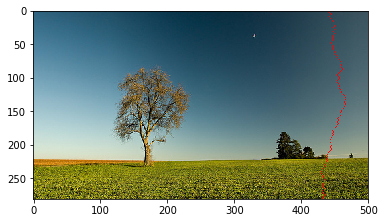

In [6]:
def reduce(img,path):
    reducedImg = np.zeros((img.shape[0],img.shape[1]-1,img.shape[2]),dtype=np.uint8)
    for i in range(img.shape[2]):
        mask = np.ones_like(img[:,:,i],bool)
        for idx in path:
            mask[int(idx[0]),int(idx[1])] = False
        reducedImg[:,:,i] = img[:,:,i][mask].reshape(reducedImg.shape[0],reducedImg.shape[1])
    return reducedImg

def extend(img, copy, path):
    resultImg = np.zeros((img.shape[0],img.shape[1]+1,img.shape[2]),dtype=np.uint8)
    resultImgCopy = np.zeros((copy.shape[0],copy.shape[1]+1,copy.shape[2]),dtype=np.uint8)
    idxs = [int(pos[0])*img.shape[1]+int(pos[1]) for pos in path]
    for i in range(img.shape[2]):
        values = [img[:,:,i][int(pos[0]),int(pos[1])] for pos in path]
        valuesIgnore = [copy[:,:,i][int(pos[0]),int(pos[1])]*100 for pos in path]
        resultImg[:,:,i] = np.reshape(np.insert(img[:,:,i], idxs, values),(resultImg.shape[0],resultImg.shape[1]))
        resultImgCopy[:,:,i] = np.reshape(np.insert(copy[:,:,i], idxs, valuesIgnore),(resultImgCopy.shape[0],resultImgCopy.shape[1]))
    return resultImg, resultImgCopy

plt.imshow(markPath(countryside, lines(countryside), mark_as='red'))

#### Resultado al reducir una imagen

In [12]:
for nlines in range(80):
    line_to_delete = lines(countryside)
    #img_with_line = markPath(countryside, line_to_delete, mark_as='red')
    #imsave('reduce_'+str(nlines)+'.jpg', img_with_line)
    countryside = reduce(countryside, line_to_delete)
    #plt.show()
    #plt.imshow(img_with_line)

C:\Users\Krizto\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


(281, 420, 3)
0 255


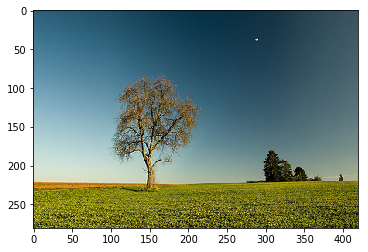

In [12]:
print(countryside.shape)
print(np.min(countryside), np.max(countryside))
plt.imshow(countryside)
plt.show()

#### Resultado al ampliar una imagen

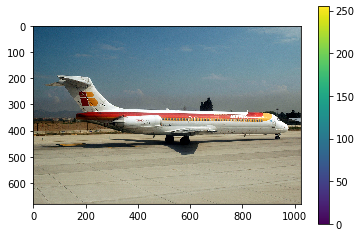

In [15]:
iberia = io.imread('iberia.jpg').astype(np.uint8)
plt.imshow(iberia)
plt.colorbar()

C:\Users\Krizto\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


(682, 1104, 3)
0 255


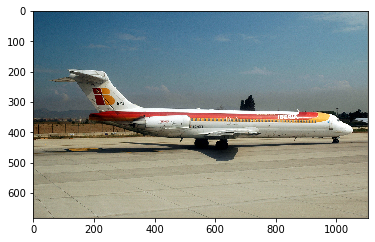

In [16]:
iberia_ignore = iberia.copy()

for nlines in range(80):
    line_to_extend = lines(iberia_ignore)
    #img_with_line = markPath(iberia, line_to_extend, mark_as='red')
    #imsave('sistesis_'+str(nlines)+'.jpg', img_with_line)
    iberia, iberia_ignore = extend(iberia, iberia_ignore, line_to_extend)

print(iberia.shape)
print(np.min(iberia), np.max(iberia))
plt.imshow(iberia)
plt.show()    

#### Esta parte solo funciona en "jupyter notebook" ya que tiene funciones de javascript habilitadas. Si usamos "jupyter lab" esta parte no funcionara. Hay que seleccionar primero la esquina superior izquierda de la figura a eliminar y luego la esquina inferior derecha.

255 0


<IPython.core.display.Javascript object>


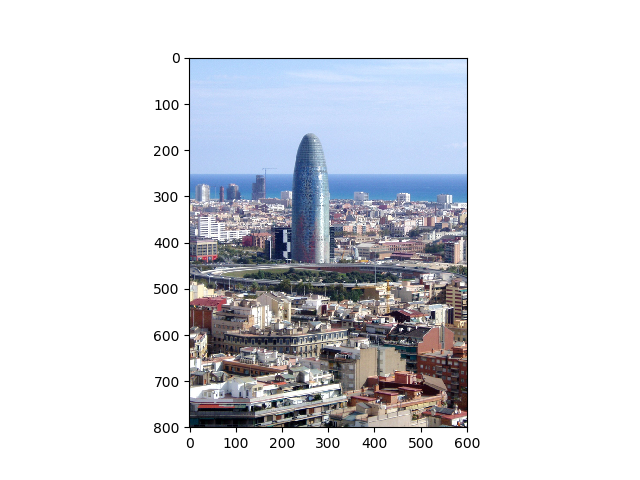

In [13]:
%matplotlib notebook

agbar = plt.imread('agbar.png')
agbar = (agbar*255).astype(np.uint)
print(np.max(agbar), np.min(agbar))
coords = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print ('x = %d, y = %d'%(
        ix, iy))

    global coords
    coords.append([int(ix), int(iy)])

    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)

    return coords


fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(agbar)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

#### Funcion alternativa para eliminar una objeto de la imagen

In [14]:
%matplotlib inline

print(coords)

def linesElimination(img, c):
    
    grad = gradient(img)
    grad[c[0][1]:c[1][1], c[0][0]:c[1][0]] = -1

    size_X, size_Y = grad.shape
    M = np.zeros((size_X,size_Y))
    #print("Lines M:", M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if(i==0):
                M[i,j]=grad[i,j]
            else:
                if(j >= M.shape[1]-1):
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j])
                else:
                    M[i,j] = grad[i,j]+min(M[i-1,j-1],M[i-1,j],M[i-1,j+1])
                    
    return backtracking(M)

[[215, 163], [309, 451]]


#### Prueba al eliminar un objeto de la imagen

95


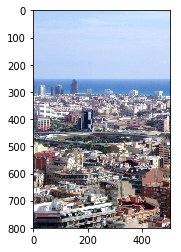

In [15]:
iterations = coords[1][0]-coords[0][0]+1
print(iterations)
for nlines in range(iterations):
    line_to_delete = linesElimination(agbar, coords)
    #img_with_line = markPath(agbar, line_to_delete, mark_as='red')
    #imsave('delete_'+str(nlines)+'.jpg', img_with_line)
    agbar = reduce(agbar, line_to_delete)
    coords[1][0]=coords[1][0]-1

plt.imshow(agbar)
plt.show()

255 0


<IPython.core.display.Javascript object>


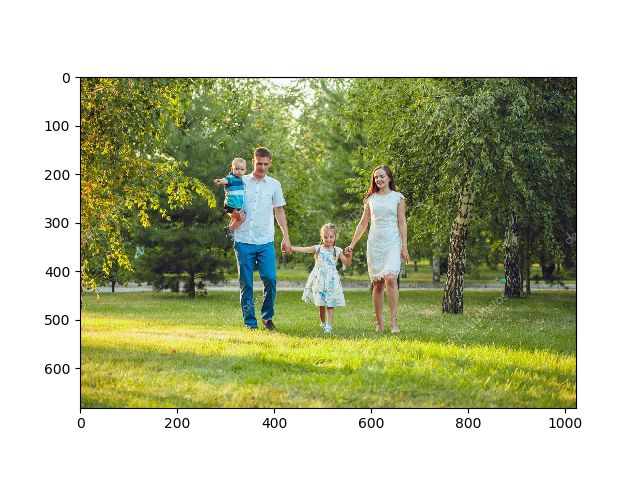

In [18]:
%matplotlib notebook

test = plt.imread('test3.jpg')
test = test.astype(np.uint)
print(np.max(test), np.min(test))
coords = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(test)
cid = fig.canvas.mpl_connect('button_press_event', onclick)

133


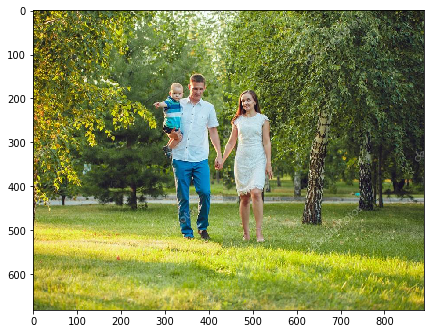

In [19]:
%matplotlib inline

iterations = coords[1][0]-coords[0][0]+1
print(iterations)
for nlines in range(iterations):
    line_to_delete = linesElimination(test, coords)
    #img_with_line = markPath(agbar, line_to_delete, mark_as='red')
    #imsave('delete_'+str(nlines)+'.jpg', img_with_line)
    test = reduce(test, line_to_delete)
    coords[1][0]=coords[1][0]-1
    
plt.figure(figsize = (7,7))
plt.imshow(test, interpolation='nearest')
plt.show()